# Multivariate Time Series forecast using seq2seq in TensorFlow

This notebook implements the cast study of applying seq2seq model for time series data. 

The purpose is to showcase the effectiveness of seq2seq to learn the true patterns under the noisy signals. In addition, we are able to implement models with flexibility such as: 

- Variable input and output sequence lengths
- Variable numbers of input and output signals 

This tutorial is divided into four parts - first we will be demonstrating how to train a basicseq2seq model on univariate data. The model is then easily applied to multivariate cases. We will then discuss about situation with outliers. And finally, we will showcase a real-world dataset to forecast pollution (pm2.5) in Beijing. 

To see the comprehensive explanations of each step, can jump to the post associated with this study - 
weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

This is a long notebook - you can choose the session of your interests by clicking on the links below: 

## Contents

### 1) <b>[Univariate time series](#session1)</b> 

### 2) <b>[Multivariate time series](#session2)</b> 

### 3) <b>[Seq2seq for outliers/extreme events](#session3)</b> 

### 4) <b>[A case study - Beijing pollution data](#session4)</b> 
data credits go to UCI - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

<a id='session1'></a>
# Univariate time series

In [1]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy
import pandas as pf
import pandas as pd

<a id='session2'></a>
# Multivariate time series: 


### Input sequences

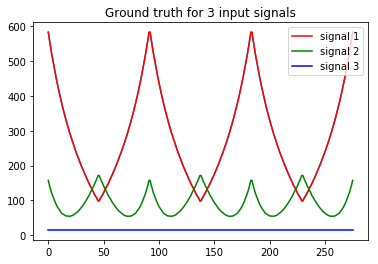

In [2]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)
#sin, cos
pf = pd.read_csv("log.csv")
cols = ['X0','Y0','A']

y1 = pf[cols[0]]
y2 = pf[cols[1]]
y3 = pf[cols[2]]
plt.plot(pf[cols[0]])

plt.title("Ground truth for 3 input signals")
l1, = plt.plot(y1, 'r', label = 'signal 1')
l2, = plt.plot(y2, 'g', label = 'signal 2')
l3, = plt.plot(y3, 'b', label = 'signal 3')

plt.legend(handles = [l1, l2, l3], loc = 'upper right')

plt.show()

### Both input and output sequences

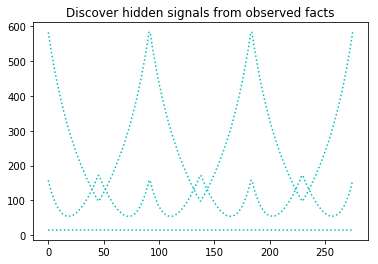

In [3]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = y1
y2 = y2
y3 = y3

plt.title("Discover hidden signals from observed facts")
l1, = plt.plot(y1, 'c:', label = 'input signals (observed facts)')
plt.plot(y2, 'c:')
plt.plot(y3, 'c:')

#l4, = plt.plot(2 * x1, 'm', label = 'output signals (hidden signals)')
#plt.plot(2 * x2, 'm') # multiplies by 2 just for visualization purpose

#plt.legend(handles = [l1, l4], loc = 'upper right')

#plt.show()

## Create function that generates training samples

In [4]:
#INPUT SEQ LEN MUST BE EQUAL TO THE AMOUNT OF ROWS MINUS THE HEADER
input_seq_len = 277
output_seq_len = 150
x = np.linspace(0, 40, 130)
#train_data_x = x[:125]
train_data_x = x[:(130 - output_seq_len)]
#110

def true_output_signals(x):
    x1 = 2 * np.sin(x)
    x2 = 2 * np.cos(x)
    return x1, x2

def true_input_signals(x):
    x1, x2 = true_output_signals(x)
    y1 = pf[cols[0]]
    y2 = pf[cols[1]]
    y3 = pf[cols[2]]
    return y1, y2, y3

def noise_func(x, noise_factor = 2):
    return np.random.randn(len(x)) * noise_factor

def generate_samples_for_output(x):
    x1, x2 = true_output_signals(x)
    return x1+noise_func(x1, 0.5), \
           x2+noise_func(x2, 0.5)

def generate_samples_for_input(x):
    y1, y2, y3 = true_input_signals(x)
    return y1+noise_func(y1, 2), \
           y2+noise_func(y2, 2), \
           y3+noise_func(y3, 2)

def generate_train_samples(x = train_data_x, batch_size = 10):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_samples_for_input(x) for x in input_seq_x]
    output_seq_y = [generate_samples_for_output(x) for x in output_seq_x]
    
    ## return shape: (batch_size, time_steps, feature_dims)
    return np.array(input_seq_y).transpose(0, 2, 1), np.array(output_seq_y).transpose(0, 2, 1)


### Visualize one data sample from training

In [5]:

input_seq, output_seq = generate_train_samples(batch_size=100)
#print(input_seq)
#print('**********************************')
#print(output_seq)
print(input_seq_len)
i1, i2, i3= plt.plot(range(input_seq_len), input_seq[0], 'yo', label = 'input_seqs_one_sample')
o1, o2 = plt.plot(range(input_seq_len,(input_seq_len+output_seq_len)), output_seq[0], 'go', label = 'output_seqs_one_sample')
plt.legend(handles = [i1, o1])
plt.show


ValueError: a must be non-empty

## Build the model

In [58]:
from build_model_multi_variate import * 

## Parameters
learning_rate = 0.1
#0.005
lambda_l2_reg = 0.05
## 0.0017
## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64
#64
# num of input signals
input_dim = 3 
# num of output signals
output_dim = 2 
# num of stacked lstm layers 
num_stacked_layers = 2
#2
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 4
#2.5

## Train the model

In [59]:
total_iteractions = 1000
# 100, 200 is best so far, 1000
batch_size = 16
#16, 16 is the best so far
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:185]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
56.554813
54.280464
56.137024
50.85056
47.607212
41.48365
41.6387
38.1329
35.930016
33.40926
30.417322
29.524214
25.795788
24.219769
23.64043
22.524155
20.78798
20.308273
17.794966
21.451706
16.469044
15.751209
17.343649
17.772884
16.349499
16.343819
14.85246
13.069555
17.425795
14.256354
13.754423
15.254949
14.232369
14.280023
14.811297
13.904276
14.910252
13.678076
14.244637
14.627054
12.705964
13.1316
12.75711
12.275493
13.6148615
12.852221
13.753755
12.890855
13.531606
13.052411
13.234987
13.531299
12.944625
13.140144
12.948308
12.500947
13.07483
12.644298
12.924248
13.137673
13.01431
12.112116
12.052162
13.289408
12.279794
12.164752
13.828154
12.286017
12.117184
12.497961
12.064286
12.134207
11.49814
11.663807
11.724459
12.715626
11.632661
11.368122
14.45854
12.463419
11.632635
12.199246
11.747741
11.677553
11.264253
11.600196
11.415501
11.41017
12.606307
10.915514
11.210018
11.695248
12.595112
11.558888
13.259673
10.914145
10.868705
11.779046
12.914531
11.591736

9.4852085
8.526786
8.936844
8.093132
9.335825
9.276952
8.305333
8.735096
8.953081
8.447726
9.009276
8.609024
8.211582
9.387918
7.980875
8.873964
9.053633
8.82615
9.07239
9.305
8.958169
9.320747
8.713541
9.365439
8.736318
9.144025
8.356363
9.604897
8.73755
9.374348
8.696179
8.694922
8.628405
8.421188
8.507938
8.744903
8.663772
8.330309
8.989384
8.399026
8.950022
8.823483
8.384888
8.264434
8.818776
8.544349
9.498683
8.757045
9.293449
8.670384
9.096853
8.64628
8.700518
8.228095
8.893299
8.945859
8.045225
9.254996
8.135922
8.8398905
8.75797
9.099066
8.331848
8.44515
8.399453
8.453336
8.480329
8.557169
9.161206
8.490995
8.388056
9.147594
8.490899
8.767166
8.129638
8.776135
8.831108
8.237022
8.393142
8.897428
8.914151
8.363807
8.84085
8.429127
8.824712
8.3610525
7.728928
9.189249
8.579718
9.503754
8.803352
8.875248
8.009734
8.955825
8.29682
9.243432
9.031853
8.462135
8.207105
8.616266
8.486888
8.396809
8.425652
9.284559
8.57267
8.105632
8.4779825
8.404405
8.631115
8.602709
8.837864
8.816805


## Inference* end of train

In [60]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'multivariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1, -1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 0)
    

INFO:tensorflow:Restoring parameters from ./multivariate_ts_model0


## Visualize predictions over true signals 

[[-0.36009213  0.37711295]
 [-0.36923525  0.5340448 ]
 [-0.347953    0.69070834]
 [-0.20890296  0.85491437]
 [ 0.04927029  0.98266226]
 [ 0.35574648  1.0011998 ]
 [ 0.63659465  0.8704524 ]
 [ 0.8563326   0.60885954]
 [ 0.99915314  0.26239595]
 [ 1.0515846  -0.11914904]
 [ 1.0013409  -0.49384576]
 [ 0.842801   -0.82955194]
 [ 0.58276016 -1.0988154 ]
 [ 0.24342261 -1.2735999 ]
 [-0.14026152 -1.3262902 ]
 [-0.5302529  -1.2378371 ]
 [-0.8930945  -1.0060303 ]
 [-1.1970202  -0.6475794 ]
 [-1.4056296  -0.1946275 ]
 [-1.4810959   0.31197408]]
[[ 0.86811543 -1.80177013]
 [ 0.27693638 -1.98073376]
 [-0.3406569  -1.97077469]
 [-0.92575828 -1.77284281]
 [-1.42256067 -1.40581689]
 [-1.78367901 -0.90470393]
 [-1.97466975 -0.31730016]
 [-1.97731617  0.30036774]
 [-1.79136585  0.88938653]
 [-1.43455477  1.39357548]
 [-0.94091562  1.76484498]
 [-0.35753179  1.96778328]
 [ 0.25995348  1.98303409]
 [ 0.85264435  1.80914279]
 [ 1.36400986  1.46269515]
 [ 1.74527589  0.97673542]
 [ 1.96007722  0.3976145 ]


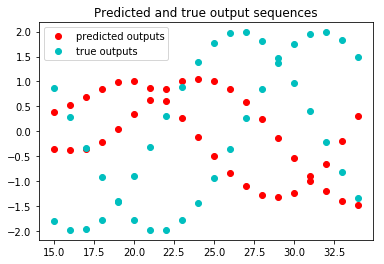

In [61]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)

plt.title("Predicted and true output sequences")
#i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), np.array(true_output_signals(x[110:])).transpose(1, 0 ), 'co', label = 'true outputs')

print(final_preds)
print(np.array(true_output_signals(x[110:])).transpose(1, 0 ))

plt.legend(handles = [p1, t1], loc = 'upper left')
plt.show()